In [1]:
import pandas as pd
import numpy as np
import math

from scipy.stats import *

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from core_io import*
from timeseriestools import*

from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch


from hurst import compute_Hc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn')


%load_ext autoreload
%autoreload 2

# An Econometric Analysis of the imbalance spot prices for the UK intraday market

# Part I: Analysis of the sample data

<AxesSubplot:title={'center':'Imbalance Prices UK'}, xlabel='time'>

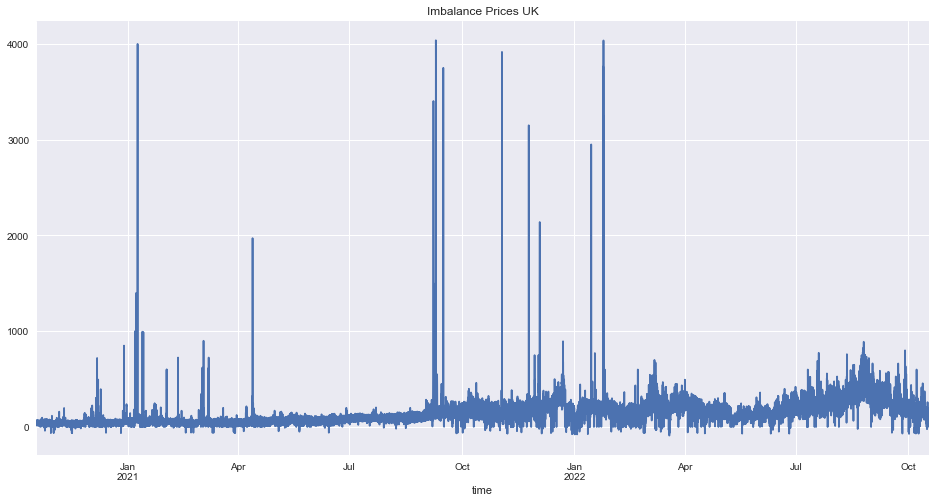

In [2]:
data = spot_imbalance(horizon = 730, resolution = '30 min')
imb_pri = data.imb
data.imb.plot(figsize = (16,8), title = 'Imbalance Prices UK')

The presented data presents some clear spikes. The majority of spikes will be classified as outliers, as for univariate sample analysis do not show a clear recurrency relation. Therefore we will be remove those outliers in the following.

<AxesSubplot:title={'center':'Cleaned imbalance Prices'}, xlabel='time'>

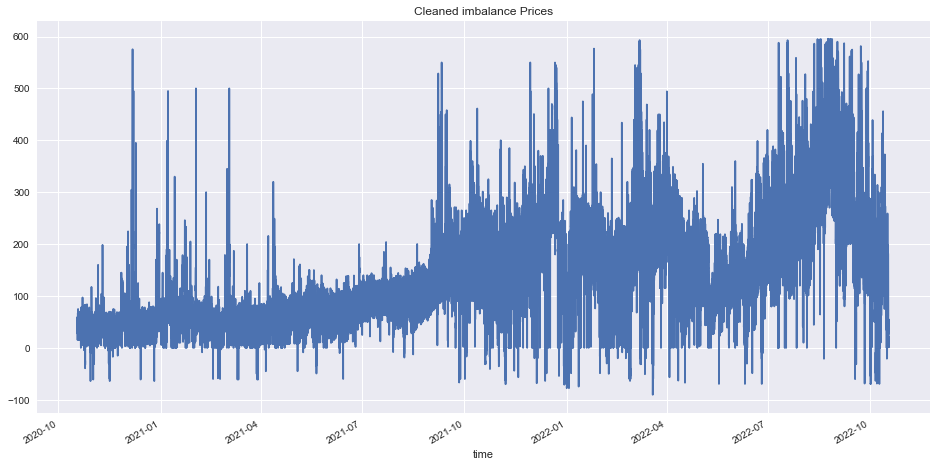

In [3]:
prices = imb_pri.to_frame('price')
prices['zscore'] = zscore(prices.price)

clean_prices = prices.query('zscore > -3 & zscore < 3').price

clean_prices.plot(figsize = (16,8), title = 'Cleaned imbalance Prices')

Next, we will be resampling the time series using different moving averages to look at trends

<AxesSubplot:xlabel='time'>

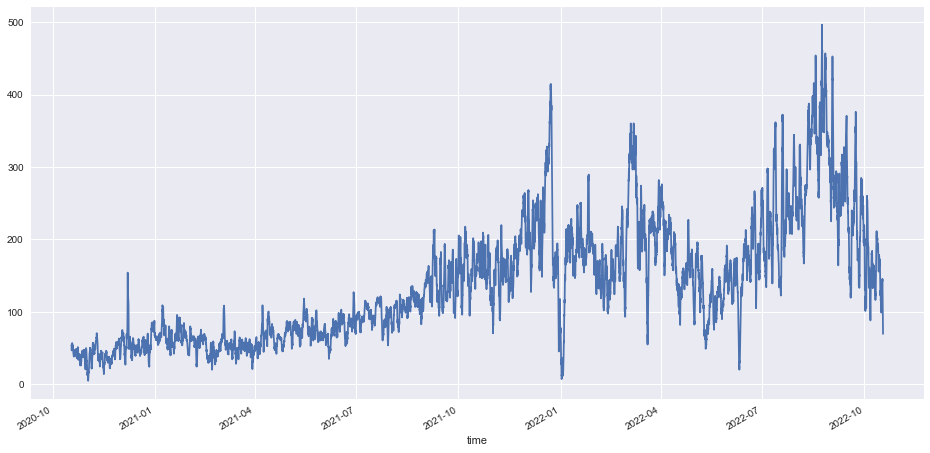

In [4]:
clean_prices.rolling('D').mean().plot(figsize = (16,8))

It is evident that the time series shows an upper trend until september 2022, with big changes in between. From the highest day we see until now a decay with big swings.

<AxesSubplot:title={'center':'Rate of Change'}, xlabel='time'>

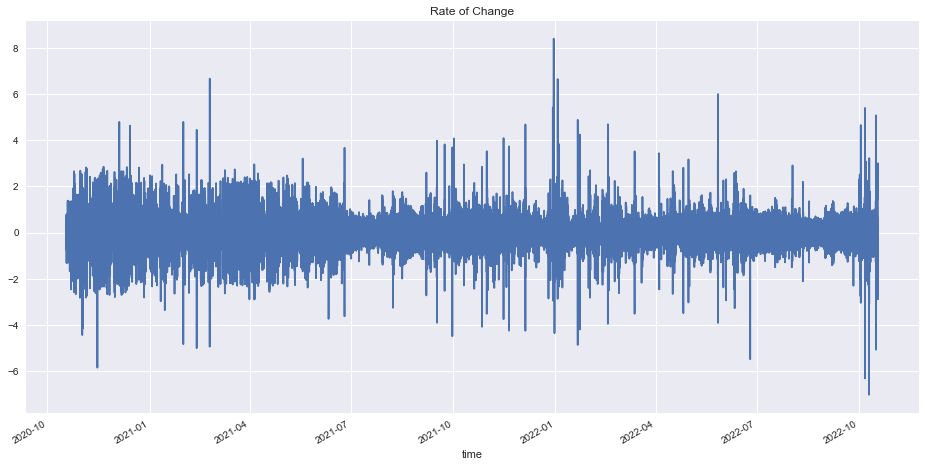

In [5]:
rates = log_return(clean_prices, period=1)

rates.plot(figsize=(16,8), title = 'Rate of Change')

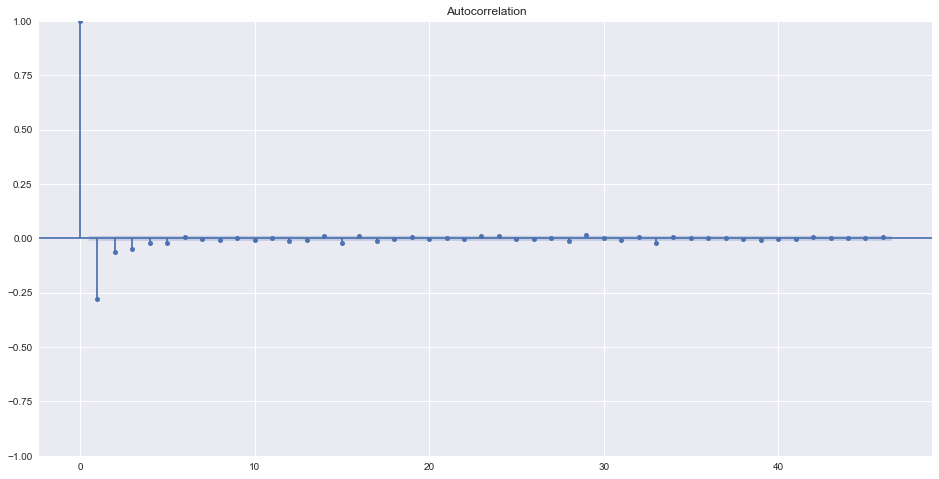

In [6]:
plt.rc("figure", figsize=(16,8))
acf = plot_acf(rates)


The autocorrelation plot suggests that there might be some empirical trends in the data. Namely, it suggests that the first 3 lags are not independent to each other, this means that there is less randomness when looking at consequent settlement periods. Moreover, being the autocorrelation negative we have that an observed increase for some time interval leads to a proportionate decrease in the lagged time interval.

On the Daily rates we have the following

<AxesSubplot:title={'center':'Rate of Change'}, xlabel='time'>

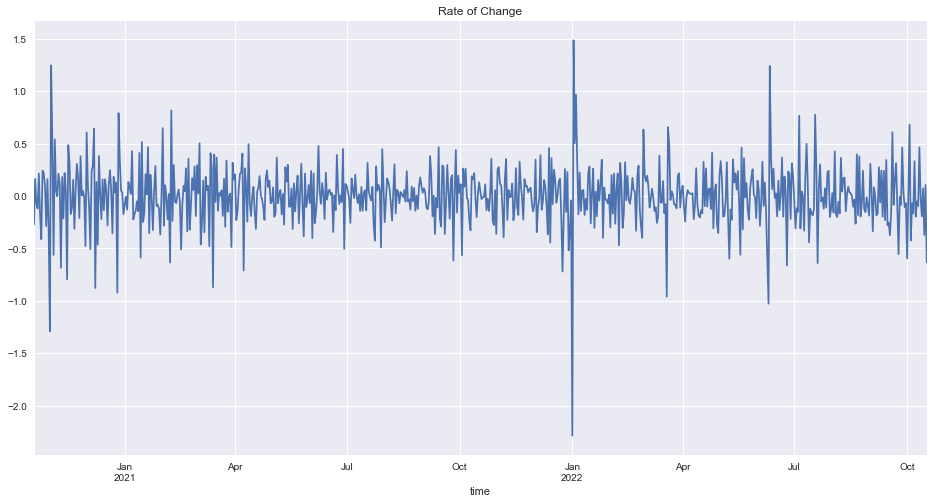

In [7]:
daily_rates = log_return(clean_prices.resample('D').mean(), period=1)

daily_rates.plot(figsize=(16,8), title = 'Rate of Change')

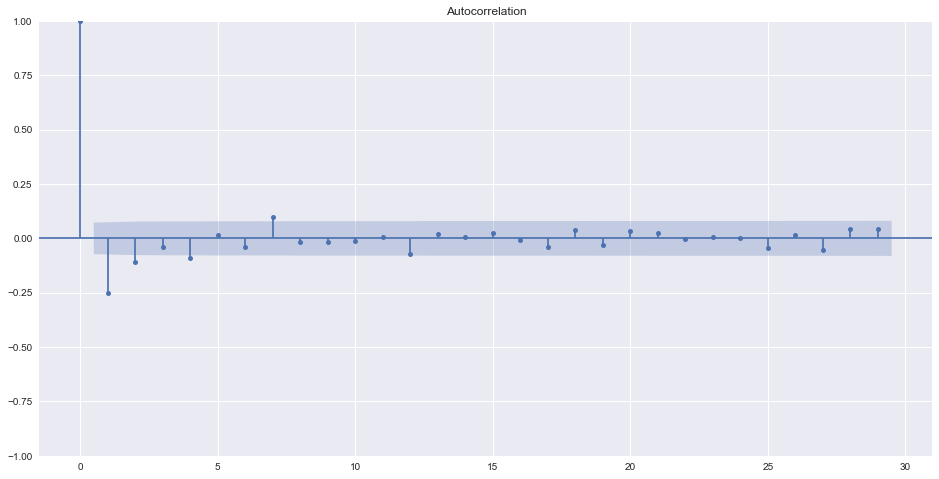

In [8]:
acf_daily = plot_acf(daily_rates)

On a daily level, the most significant lags are the first, the second and the 7th. 

# Stationarity Test and Mean Reversion

In [9]:
#Unit root test for stationarity

dickey_fuller_test(rates)

Augmented Dickey-Fuller test
Test statistic: -29.7549
-----------------------------------
p-value: 0.0
-----------------------------------
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Hypothesis Testing Results
Null Hyptothesis (H0): True


In [10]:
#Hidden trend stationarity test

kpss_test(rates)

Kwiatkowski-Phillips-Schmidt-Shin test
Test statistic: 0.025776552474682836
-----------------------------------
p-value: 0.1
-----------------------------------
num lags: 231
-----------------------------------
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Hypothesis Testing Results
Result: The series is stationary


In [11]:
# Mean Reversion

compute_Hc(rates)[0]

0.2415812841458924

The time series is stationary and trend stationary. It shows mean reversion.

# Volatility Clustering

<AxesSubplot:xlabel='time'>

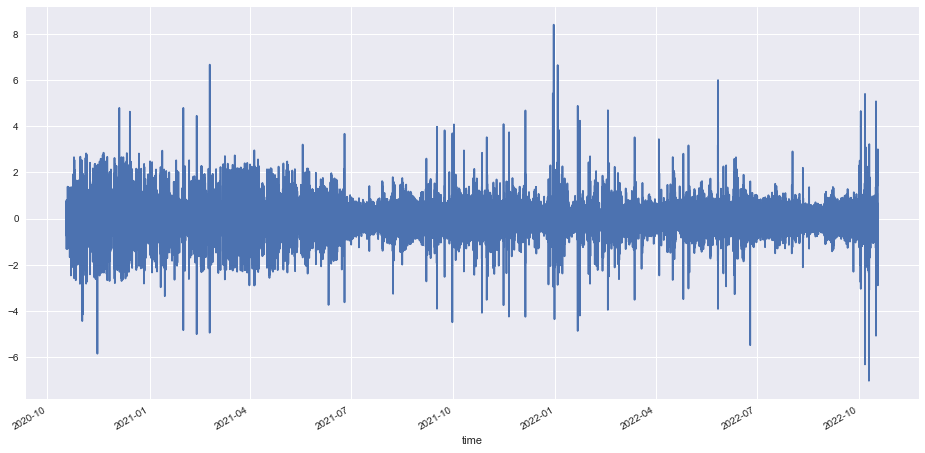

In [12]:
rates.plot(figsize=(16,8))

<AxesSubplot:title={'center':'demeaned rate of returns'}, xlabel='time'>

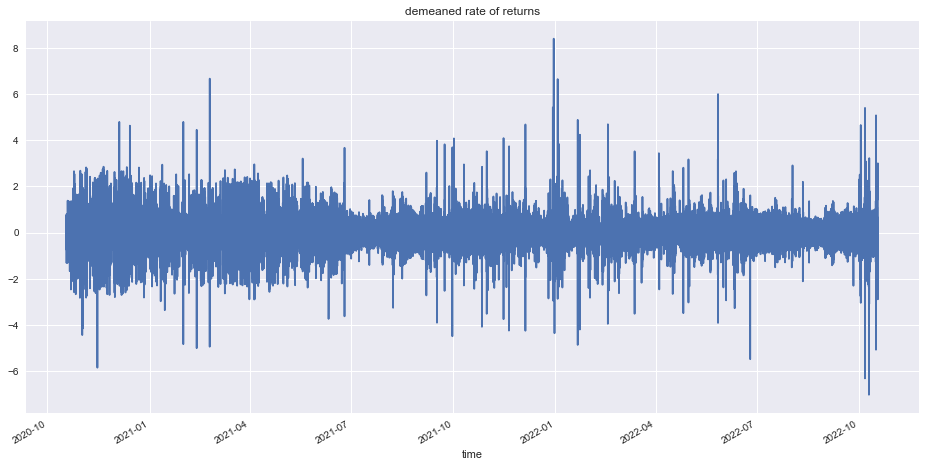

In [13]:
demeaned_rates = rates - rates.mean()

demeaned_rates.plot(figsize = (16,8), title = 'demeaned rate of returns')

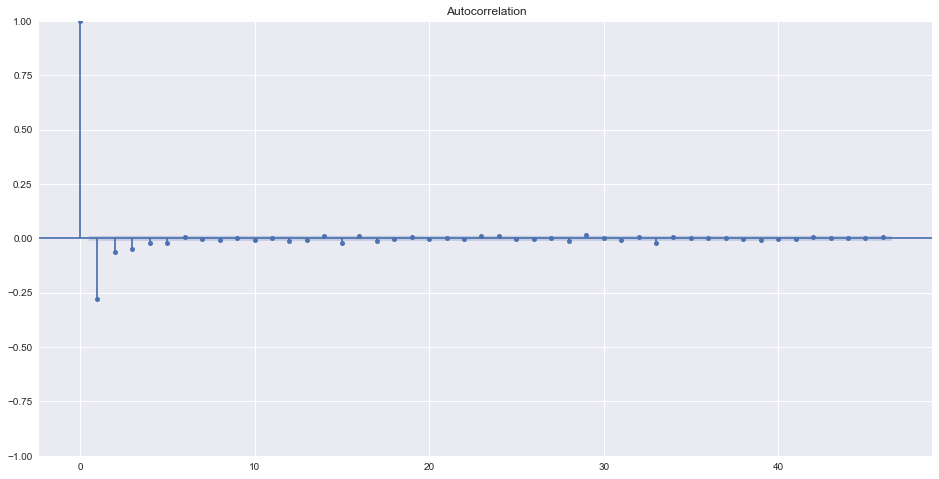

In [14]:
plt.rc("figure", figsize=(16,8))
acf = plot_acf(demeaned_rates)

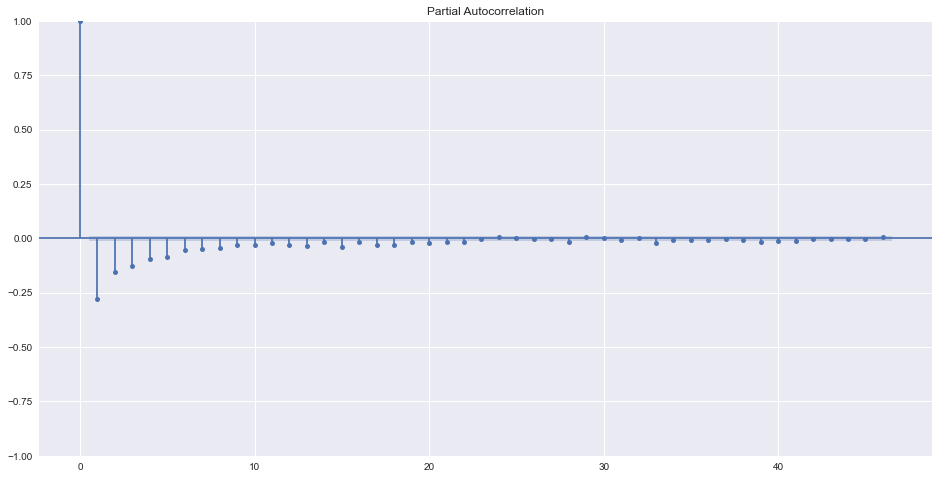

In [15]:
pacf = plot_pacf(demeaned_rates)

0.22360446043844995

In [16]:
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p=p, q=q, dist='normal')
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_model(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score: 
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models
                
def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, maxlag=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results

In [17]:
p_rng = range(0,10)
q_rng = range(0,5)

top_models = gridsearch(demeaned_rates, p_rng, q_rng)
print(top_models)

[{'LM_pvalue': [0.0, True], 'F_pvalue': [0.0, True], 'SW_pvalue': [0.0, True], 'AIC': 45418.31259203266, 'params': {'p': 1, 'q': 4}}]


c:\code\Helios.AlgoTrading.UK\.venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


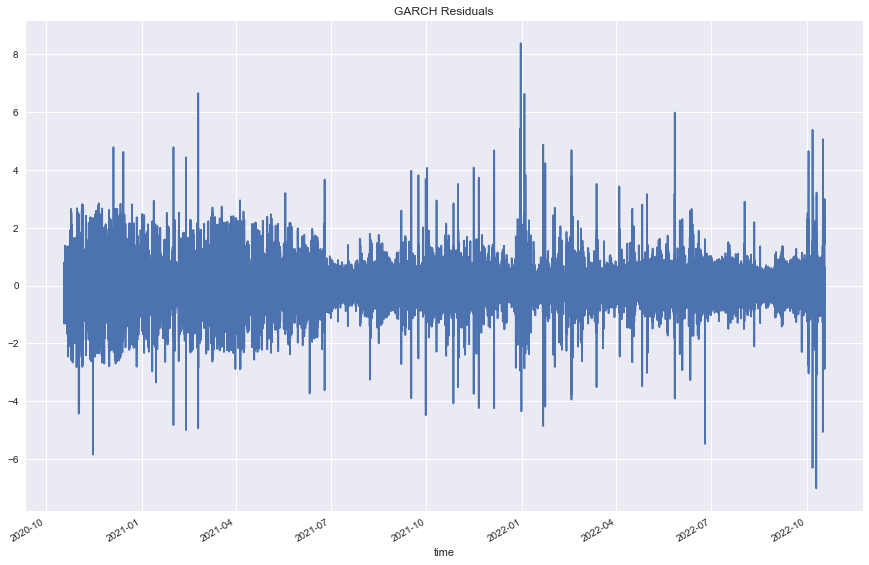

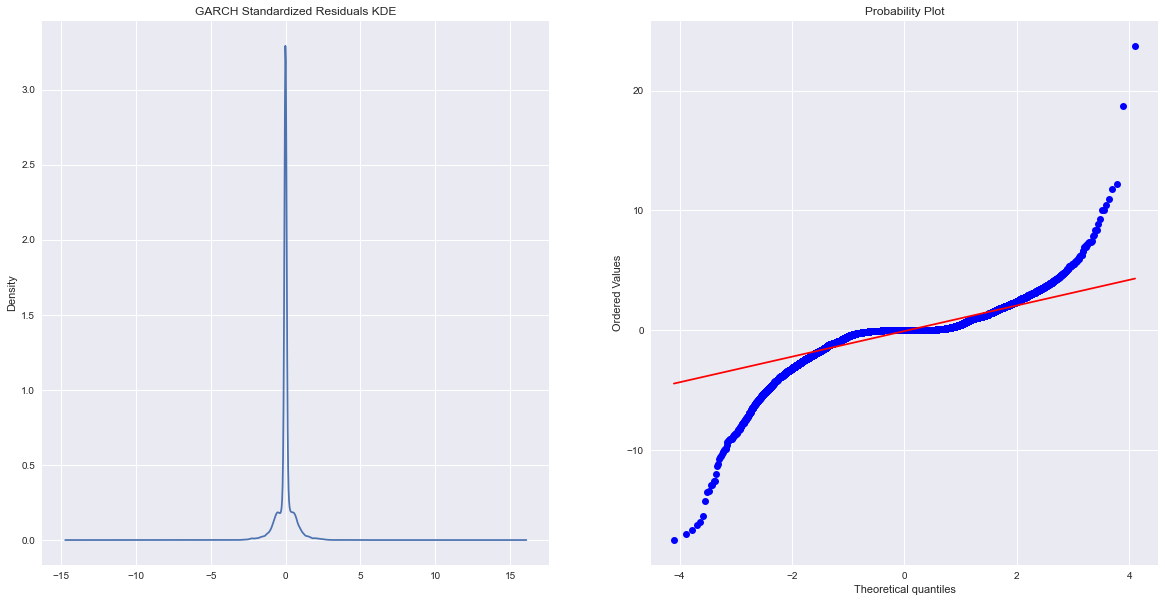

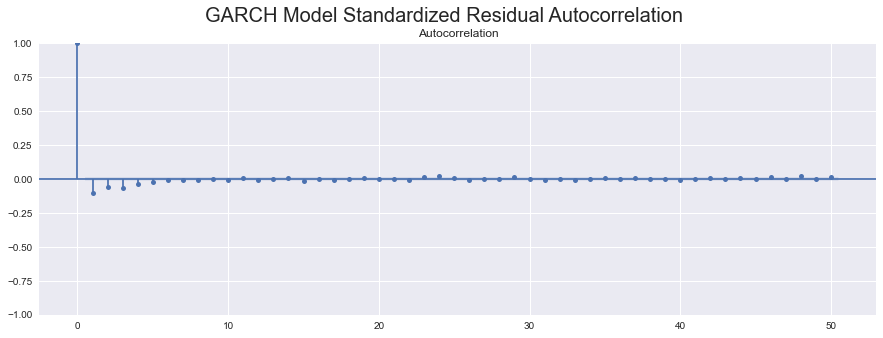

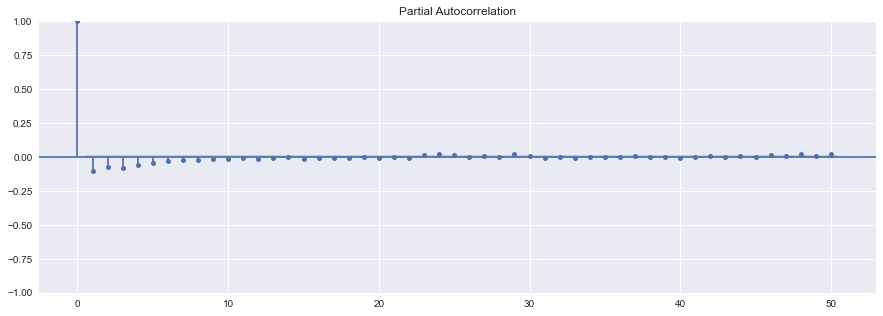

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                        price   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -9346.55
Distribution:      Standardized Student's t   AIC:                           18709.1
Method:                  Maximum Likelihood   BIC:                           18776.6
                                              No. Observations:                33983
Date:                      Tue, Oct 18 2022   Df Residuals:                    33982
Time:                              10:58:33   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.6416e-04  3.570e-04      1.580      0.114 [-1.355e-04,1.264e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0406  1.056e-02      3.844  1.212e-04  [1.989e-02,6.127e-02]
alpha[1]       0.6573  2.027e-02     32.424 1.246e-230      [  0.618,  0.697]
beta[1]        0.3233  7.119e-02      4.542  5.585e-06      [  0.184,  0.463]
beta[2]    5.1044e-03  3.606e-02      0.142      0.887 [-6.558e-02,7.579e-02]
beta[3]    1.7109e-05  2.330e-02  7.342e-04      0.999 [-4.566e-02,4.569e-02]
beta[4]        0.0144  1.412e-02      1.019      0.308 [-1.329e-02,4.205e-02]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.1702  5.913e-03    367.023      0.000 [  2.159,  2.182]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

In [25]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()
    
    
garch = arch_model(demeaned_rates, vol='GARCH', p=1, q=4, power = 2, dist='t')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
fgarch.summary()

# Analysis on Panel Data

In [26]:
panel_df = create_panel_df(imb_pri)
return_df = log_return(panel_df, period=1)

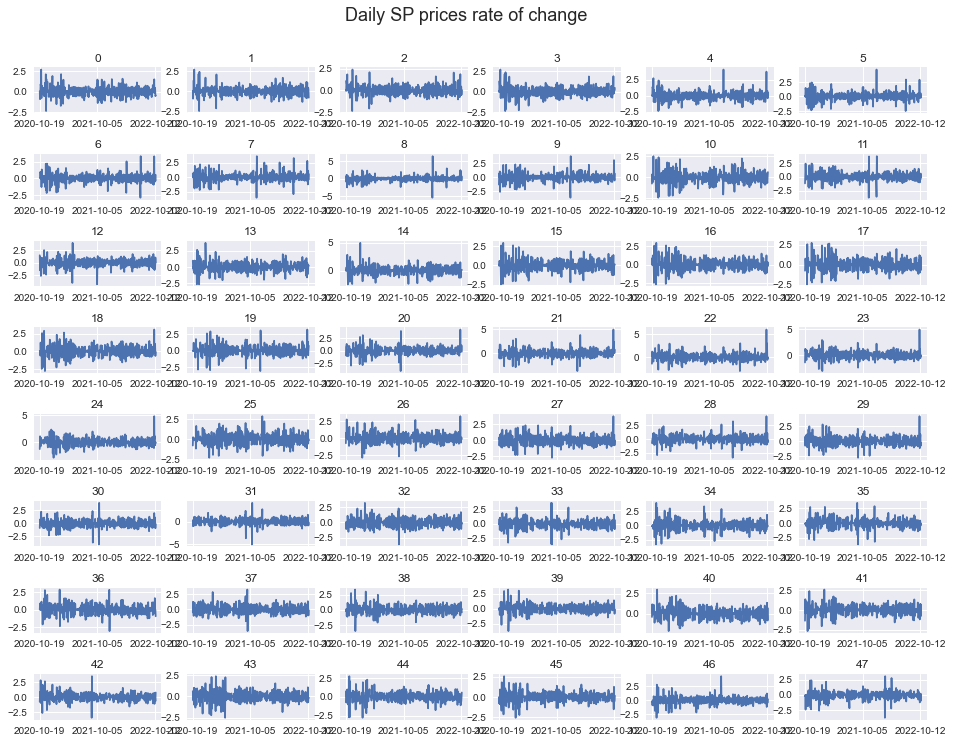

In [27]:
# define subplot grid
fig, axs = plt.subplots(nrows=8, ncols=6, figsize=(16, 12))
plt.subplots_adjust(hspace=0.9)
fig.suptitle("Daily SP prices rate of change", fontsize=18, y=0.95)

# loop through tickers and axes
for ticker, ax in zip(panel_df, axs.ravel()):
    # filter df for ticker and plot on specified axes
    return_df[ticker].plot(ax=ax)

    # chart formatting
    ax.set_title(ticker)
    ax.get_legend()
    ax.set_xlabel("")

plt.show()

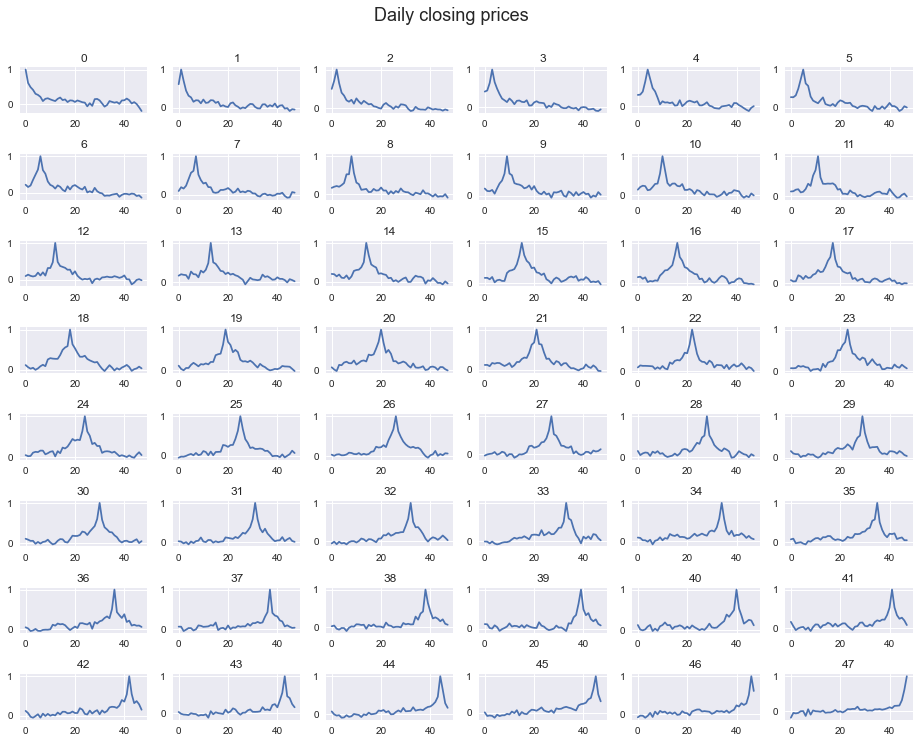

In [28]:
# define subplot grid
fig, axs = plt.subplots(nrows=8, ncols=6, figsize=(16, 12))
plt.subplots_adjust(hspace=0.9)
fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through tickers and axes
for ticker, ax in zip(panel_df, axs.ravel()):
    # filter df for ticker and plot on specified axes
    return_df.corr().loc[ticker].plot(ax=ax)

    # chart formatting
    ax.set_title(ticker)
    ax.get_legend()
    ax.set_xlabel("")

plt.show()


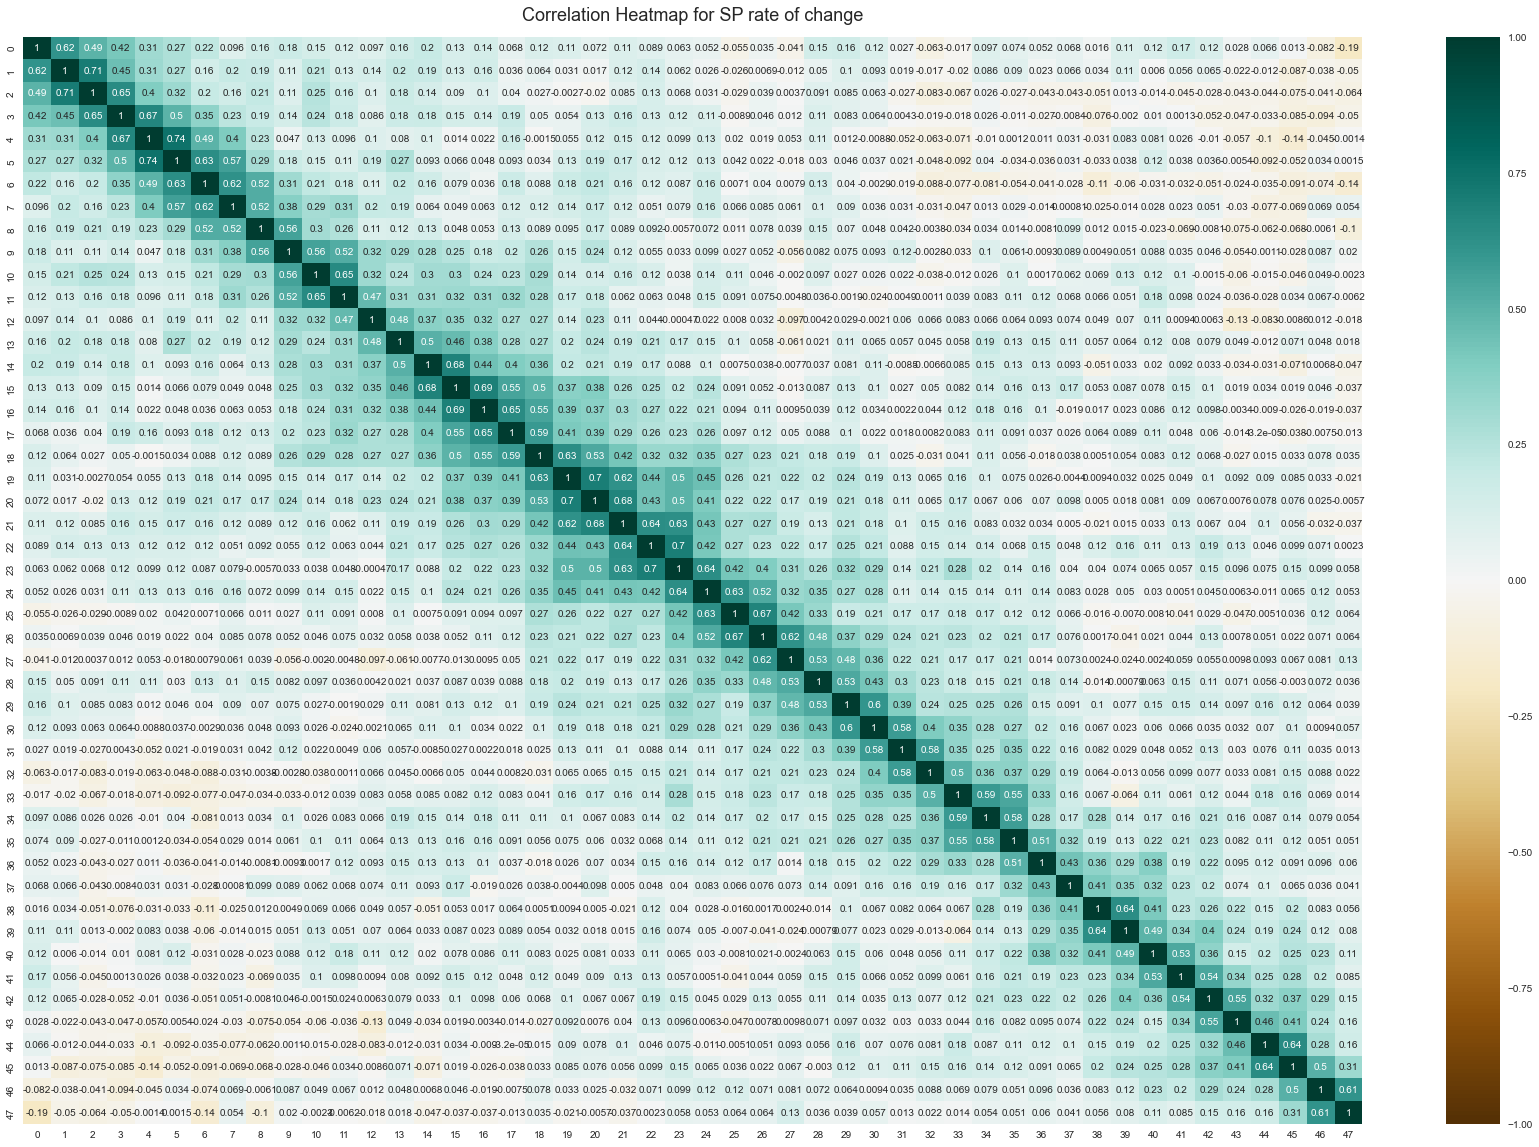

In [30]:
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(return_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap for SP rate of change', fontdict={'fontsize':18}, pad=16);